<a href="https://colab.research.google.com/github/H93JEBALI/Stock-Crypto-prediction/blob/main/Price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real time collect of BTC price Data from Yahoo Finance API

In [25]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

In [40]:
btc = yf.Ticker('BTC-USD')

# get stock info
print(btc.info)

# get historical market data
hist_btc = btc.history(period="3y",  interval = '1d')

{'companyOfficers': [], 'name': 'Bitcoin', 'startDate': 1367107200, 'description': 'Bitcoin (BTC) is a cryptocurrency . Users are able to generate BTC through the process of mining. Bitcoin has a current supply of 18,865,956. The last known price of Bitcoin is 62,005.54122396 USD and is up 1.32 over the last 24 hours. It is currently trading on 8291 active market(s) with $29,607,712,723.65 traded over the last 24 hours. More information can be found at https://bitcoin.org/.', 'maxAge': 1, 'exchange': 'CCC', 'shortName': 'Bitcoin USD', 'exchangeTimezoneName': 'Europe/London', 'exchangeTimezoneShortName': 'GMT', 'isEsgPopulated': False, 'gmtOffSetMilliseconds': '0', 'quoteType': 'CRYPTOCURRENCY', 'symbol': 'BTC-USD', 'messageBoardId': 'finmb_BTC_CCC', 'market': 'ccc_market', 'previousClose': 61528.2, 'regularMarketOpen': 61528.2, 'twoHundredDayAverage': 45378.215, 'trailingAnnualDividendYield': None, 'payoutRatio': None, 'volume24Hr': 25909876736, 'regularMarketDayHigh': 62356.777, 'navP

In [48]:
hist_btc.reset_index(drop = False, inplace = True)
hist_btc['Day'] = hist_btc['Date']
hist_btc.set_index('Date', inplace = True)

In [49]:
hist_btc.head()

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,Day
Date,,,,,,,,,
2018-11-07,0,6468.500000,6552.160156,6468.310059,6530.140137,4941260000,0,0,2018-11-07
2018-11-08,1,6522.270020,6536.919922,6438.529785,6453.720215,4665260000,0,0,2018-11-08
2018-11-09,2,6442.600098,6456.459961,6373.370117,6385.620117,4346820000,0,0,2018-11-09
2018-11-10,3,6386.129883,6437.279785,6385.310059,6409.220215,3705320000,0,0,2018-11-10
2018-11-11,4,6413.629883,6423.250000,6350.169922,6411.270020,3939060000,0,0,2018-11-11


In [50]:
#declare figure
fig = go.Figure()

#Candlestick
fig.add_trace(go.Candlestick(x=hist_btc.index,
                open=hist_btc['Open'],
                high=hist_btc['High'],
                low=hist_btc['Low'],
                close=hist_btc['Close'],
                name = 'market data'))

# Add titles
fig.update_layout(
    title='Bitcoin live share price evolution',
    yaxis_title='Bitcoin Price (kUS Dollars)')

# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=7, label="7d", step="day", stepmode="backward"),
            dict(count=1, label="1M", step="month", stepmode="backward"),
            dict(count=6, label="6M", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)


fig.update_layout(
    title='Halving',
    yaxis_title= 'Bitcoin Price (kUS Dollars)',
    shapes = [dict(
        x0='2020-05-11', x1='2020-05-11', y0=0, y1=1, xref='x', yref='paper',
        line_width=2)],
    annotations=[dict(
        x='2020-05-11', y=0.05, xref='x', yref='paper',
        showarrow=False, xanchor='left', text='BTC halving')]
)

#Show
fig.show()

# ***Data to be used to predict the next price sequence using the trained model***

In [52]:
hist_btc_prd = hist_btc[hist_btc['Day'] >= '2021-09-01']
hist_btc_prd.head(5)

,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,Day
Date,,,,,,,,,
2021-09-01,1025,47099.773438,49111.089844,46562.437500,48847.027344,39139399125,0,0,2021-09-01
2021-09-02,1026,48807.847656,50343.421875,48652.320312,49327.722656,39508070319,0,0,2021-09-02
2021-09-03,1027,49288.250000,50982.273438,48386.085938,50025.375000,43206179619,0,0,2021-09-03
2021-09-04,1028,50009.324219,50545.582031,49548.781250,49944.625000,37471327794,0,0,2021-09-04
2021-09-05,1029,49937.859375,51868.679688,49538.597656,51753.410156,30322676319,0,0,2021-09-05


# **Train a prediction model using LSTMs and a historical data exported from coinbase exchange**

In [54]:
# Load data
df_c = pd.read_csv('coinbaseUSD.csv')
df_c.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


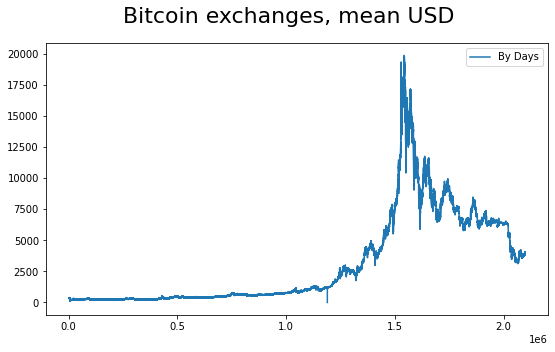

In [55]:
import matplotlib.pyplot as plt

# PLOTS
fig = plt.figure(figsize=[9, 5])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.plot(df_c.Weighted_Price, '-', label='By Days')
plt.legend()

# plt.tight_layout()
plt.show()

In [56]:
df_c['date'] = pd.to_datetime(df_c['Timestamp'],unit='s').dt.date
group = df_c.groupby('date')
Real_Price = group['Weighted_Price'].mean()

In [57]:
# split data
prediction_days = 200
df_train= Real_Price[len(Real_Price)-prediction_days:]
df_test= Real_Price[:len(Real_Price)-prediction_days]

In [58]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# Data preprocess
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [59]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50, activation = 'sigmoid', input_shape = (None, 1)))   #relu

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

Epoch 1/100
40/40 [==============================] - 2s 2ms/step - loss: 0.4585
Epoch 2/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0812
Epoch 3/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0534
Epoch 4/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0515
Epoch 5/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0496
Epoch 6/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0479
Epoch 7/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0456
Epoch 8/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0435
Epoch 9/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0414
Epoch 10/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0388
Epoch 11/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0366
Epoch 12/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0343
Epoch 13/100
40/40 [=================

In [60]:
test_set = df_test.values[1:]
sc = MinMaxScaler()
inputs = np.reshape(df_test.values[0:len(df_test)-1], (len(test_set), 1))
inputs = sc.fit_transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

In [61]:
df_test.values[1:]

array([ 377.85491071,  377.81833333,  377.1       , ..., 6717.36848802,
       6679.92939485, 6733.64600356])

In [62]:
predicted_BTC_price

array([[ 424.1825 ],
       [ 466.82828],
       [ 466.79324],
       ...,
       [6610.832  ],
       [6804.8413 ],
       [6767.333  ]], dtype=float32)

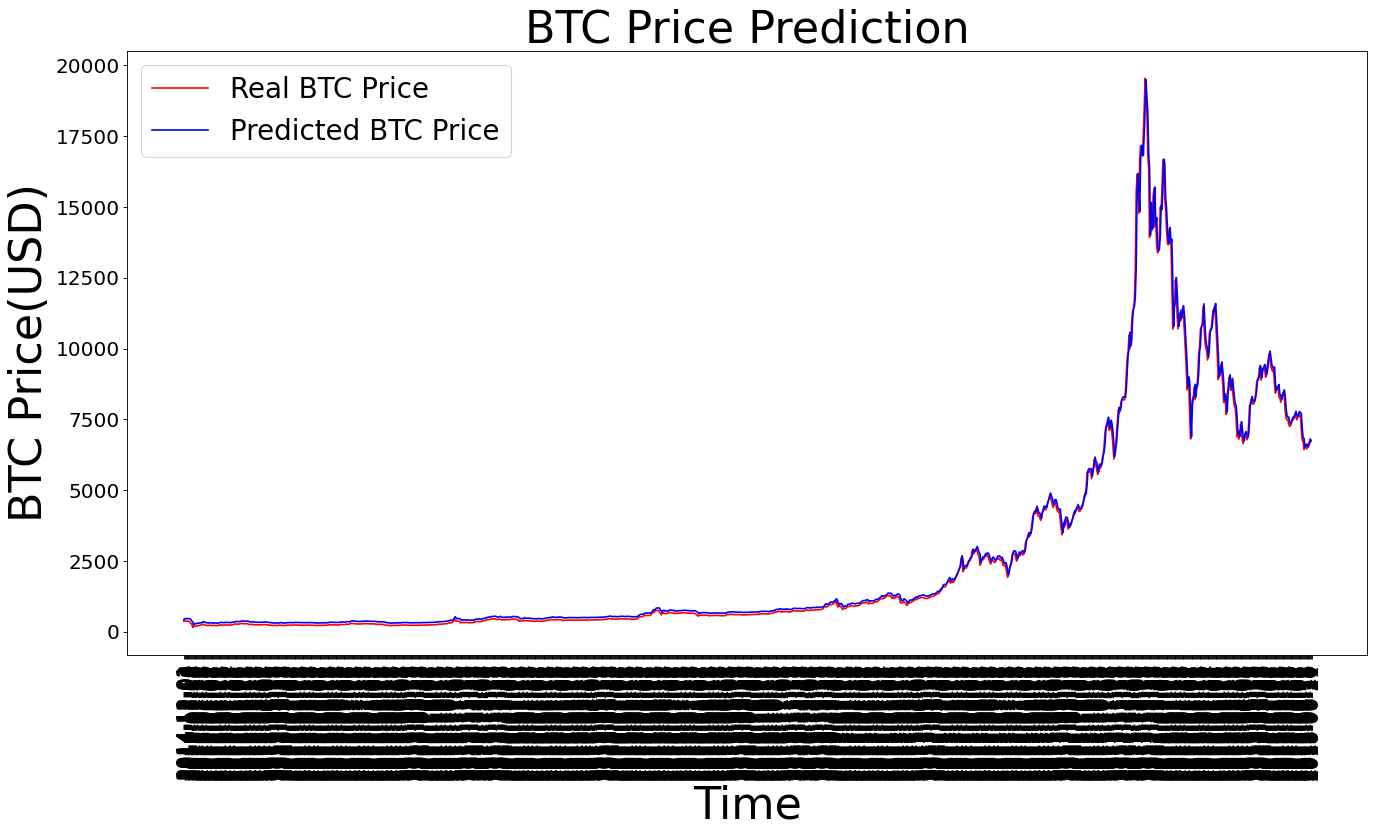

In [63]:
plt.figure(figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
df_test = df_test.reset_index()
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

# **Predict BTC price using the Yahoo Finance history for the last 60 days**

In [74]:
hist_btc_prd[['Day', 'Close']].head(10)

,Day,Close
Date,,
2021-09-01,2021-09-01,48847.027344
2021-09-02,2021-09-02,49327.722656
2021-09-03,2021-09-03,50025.375000
2021-09-04,2021-09-04,49944.625000
2021-09-05,2021-09-05,51753.410156
2021-09-06,2021-09-06,52633.535156
2021-09-07,2021-09-07,46811.128906
2021-09-08,2021-09-08,46091.390625
2021-09-09,2021-09-09,46391.421875


In [70]:
from sklearn.preprocessing import MinMaxScaler


pred_set = hist_btc_prd['Close'].values[0:]

sc = MinMaxScaler()
inputs = np.reshape(pred_set, (len(pred_set), 1))
inputs = sc.fit_transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))

predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

In [86]:
df_predicted_BTC_price = pd.DataFrame(list(zip(predicted_BTC_price, list(hist_btc_prd['Day'].values[0:]))), columns=['Predicted price', 'Day'])

In [90]:
df_predicted_BTC_price.tail(1)

,Predicted price,Day
67,[62131.766],2021-11-07
